<a href="https://colab.research.google.com/github/vedantpople4/AiProjects/blob/main/Follow_us_Go_to_production_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recap from Part 1

* We covered how to set up and work with **dlt sources and resources**.
* Learned how to **configure secrets** for dlt pipelines.
* Explored **incremental loading** and saw how simple it is to implement with dlt.
* Reviewed the available **verified sources** and **destinations** in dlt.
* Discussed how to use the **filesystem** as both a source and a destination.
* Looked at how to **adjust and customize schemas** to fit your data needs.
* Took a closer look at the **metadata** that dlt pipelines generate.


At the end of the previous workshop we got something similar to the pipeline below:

In [ ]:
%%capture
!pip install dlt

In [ ]:
import os
import dlt
from dlt.sources.helpers import requests

from google.colab import userdata

dlt.secrets["access_token"] = userdata.get('ACCESS_TOKEN')
# os.environ["ACCESS_TOKEN"] = userdata.get('ACCESS_TOKEN')


def pagination(url, access_token):
    while True:
        # response = requests.get(url) # uncomment this line if you want to run the pipeline without authentication
        response = requests.get(url, headers={"Authorization": f"Bearer {access_token}"}) # comment this line if you want to run the pipeline without authentication
        response.raise_for_status()
        yield response.json()

        # Get next page
        if "next" not in response.links:
            break
        url = response.links["next"]["url"]


@dlt.resource(table_name="issues")
def get_issues(
    access_token=dlt.secrets.value,
    updated_at=dlt.sources.incremental("updated_at", initial_value="1970-01-01T00:00:00Z")
):
    url = f"https://api.github.com/repos/dlt-hub/dlt/issues?since={updated_at.last_value}"
    yield pagination(url, access_token)


@dlt.resource(table_name="pulls")
def get_pulls(
    access_token=dlt.secrets.value,
    updated_at=dlt.sources.incremental("updated_at", initial_value="1970-01-01T00:00:00Z")
):
    url = f"https://api.github.com/repos/dlt-hub/dlt/pulls?since={updated_at.last_value}"
    yield pagination(url, access_token)


@dlt.source
def github_data():
  return get_issues(), get_pulls()


pipeline = dlt.pipeline(
    pipeline_name="github",
    destination="duckdb",
    dataset_name="github_data",
    dev_mode=True,
)
pipeline.run(github_data(), write_disposition="replace")
print(pipeline.last_trace)

So now you know
* how to use decorators `@dlt.source` and `@dlt.resource`,
* how to make them incremental,
* how `dlt.secrets` works,
* how to define and run dlt pipeline,
* what types of `write_disposition` has dlt,  
* how to look at the last trace.

# Table of content for Part 2: Go-to-production

0. [SQL databases as a source](https://colab.research.google.com/drive/1zchNalJkGp13nn-0Xp7bflZ4x_XOb7iN#scrollTo=zxdnkmikbUkj)
1. [Custom incremental loading](https://colab.research.google.com/drive/1C7KSuFhhD6mGc-uPm8gtMZm18YFT7hvO?usp=sharing)
2. [Schema Configuration & Data Contracts](https://colab.research.google.com/drive/1RTAeZIbuMvKQxlGVJ0n3TeQF2w_ZFg9e#scrollTo=zpdr61NpqbZz)
3. [Tracing, Logging ](https://colab.research.google.com/drive/1CR8MaiYPbjS4xSFegq3b9fZdKmiwjloJ?usp=drive_link)
4. [Retries](https://colab.research.google.com/drive/10FgjtqzamGY9YUyeyKyzeZ1b2ReRvOD7?usp=drive_link)
5. [Bonus: dbt Runner](https://colab.research.google.com/drive/1tHA6gJVjKGdBDkHD3ByO5k6xsxy0z2cI?usp=drive_link)
6. [Performance Optimization](https://colab.research.google.com/drive/1vzixI_gWhp_g9me2_raIW2qoo16n4q_f?usp=drive_link)
7. [Custom sources with RestAPI helpers](https://colab.research.google.com/drive/1NbHbvbx1HD8NRIO1eaznHMd0kZg6ykrD?usp=drive_link)
8. [Custom destinations: Reverse ETL](https://colab.research.google.com/drive/1UA4UCSO5UGngu_upUvorvPuarSxw7wVK?usp=drive_link)
9. Deployment with GitHub Actions, Lambda Function & Dagster

# 1. **Custom incremental loading**

Implement custom strategies for incremental loading, including lookback periods, and backfill techniques, using `last_value_func`. These methods will help you efficiently manage data updates and ensure your pipelines are always up to date.

Find more in the Colab: [Custom incremental loading](https://colab.research.google.com/drive/1C7KSuFhhD6mGc-uPm8gtMZm18YFT7hvO?usp=sharing).


By default, the **max** cursor value is stored as the last value : `last_value_func=max`.

### Task 1: Change it to **min**.

In the example below, we changing the incremental settings for the resourse `get_issues`, e.g. `initial_value="2024-01-01T00:00:00Z"` means that we want to get issues only for this year (since Jan 1st, 2024).

If you change `last_value_func` to **min**, no data will be loaded. This happens because dlt will attempt to load data that is less than the `last_value`. However, since the `last_value` will always be Jan 1st, 2024, and we are using a `since` filter (which ensures data is only requested after the `last_value`), no matching data will be retrieved.

In [ ]:
data = github_data()

issues_resource = data.get_issues.apply_hints(
    incremental = dlt.sources.incremental(
        "updated_at",
        initial_value="2024-01-01T00:00:00Z",
        last_value_func=max # TODO
    )
)

Run the pipeline

In [ ]:
pipeline = dlt.pipeline(
    pipeline_name="github_issues_last_value_func",
    destination="duckdb",
    dataset_name="github_data_merge",
    dev_mode=True,
)
pipeline.run(issues_resource)
print(pipeline.last_trace)

In [ ]:
!cat /var/dlt/pipelines/github_issues_last_value_func/state.json

### Task 2: Backfill with `end_value`
Load data only for June.

In [ ]:
pipeline = dlt.pipeline(
    pipeline_name="github_issues_backfill",
    destination="duckdb",
    dataset_name="github_data_merge",
    dev_mode=True,
)

load_info = pipeline.run(
    issues_resource.apply_hints(
        incremental=dlt.sources.incremental(
            "updated_at",
            initial_value="1970-01-01T00:00:00Z", # TODO
            end_value="1999-07-01T00:00:00Z" # TODO
        )
    )
)
print(pipeline.last_trace.last_normalize_info)
print(load_info)

import duckdb

conn = duckdb.connect(f'{pipeline.pipeline_name}.duckdb')
dates = conn.sql(f'select * from {pipeline.dataset_name}.issues').df()['updated_at']

print("\nMax date: ", max(dates), "Min date: ", min(dates))

# 2. **Schema Configuration & Data Contracts**
    
Delve into schema configuration and data contracts. This module covers setting data types, enabling autodetection, and establishing data contracts to ensure data integrity and consistency across your pipelines.

More on dlt Data Contracts in the [Schema Configuration & Data Contracts](https://colab.research.google.com/drive/1RTAeZIbuMvKQxlGVJ0n3TeQF2w_ZFg9e) Colab.


In [ ]:
%%capture
!pip install dlt[duckdb]

Imagine you’ve decided to track specific issues from the `dlt` GitHub repository. You start by loading issue `#1708` into a DuckDB table called `issues`.


In [ ]:
import dlt
from dlt.sources.helpers import requests

# Hypothetically fetching data for issue #1708 using dlt's requests wrapper
response = requests.get("https://api.github.com/repos/dlt-hub/dlt/issues/1708")
data = response.json()

# Create your pipeline
pipeline = dlt.pipeline(
    pipeline_name="github", destination="duckdb", dataset_name="issues"
)

# Load the data
load_info = pipeline.run([data], table_name="issues")
print(load_info)

# Print the row counts for each table that was loaded in the last run of the pipeline
print("\nNumber of new rows loaded into each table: ", pipeline.last_trace.last_normalize_info.row_counts)

## Task 3: Set Data contract

Now, let’s say the next day, you decide to fetch all issues from the `dlt` repository. However, you want to ensure that your existing schema remains intact:

- You choose `"tables" : "freeze"` to prevent any new tables from being added.
- You select `"columns" : "discard_value"` to ignore any new columns that other issues might introduce.
- Finally, you set `"data_type" : "discard_row"` to discard any rows with unexpected data types, avoiding potential schema conflicts.

In [ ]:
@dlt.resource(
    schema_contract={
           # TODO
           # TODO
           # TODO
    }
)
def issues():
    url = "https://api.github.com/repos/dlt-hub/dlt/issues"
    response = requests.get(url)
    data = response.json()
    yield data

load_info = pipeline.run(issues, table_name="issues")

print(load_info)

**Oops! The pipeline failed 🥺.** The error indicates that the pipeline tried to create a child table `issues__labels`, but it wasn't allowed because tables are frozen. You inspect the JSON of issue `#1708` and notice that the `labels` field is empty:

```
{
  "url": "https://api.github.com/repos/dlt-hub/dlt/issues/1708",
  "labels": [],
  ...
}
```

This is why the `issues__labels` child table wasn't created when you loaded the data for issue `#1708`. To handle issues where the `labels` field is NOT empty, you decide to allow the schema to evolve by setting `tables` back to `evolve`.

In [ ]:
@dlt.resource(
    schema_contract={
            # TODO
            # TODO
            # TODO
    }
)
def issues():
    url = "https://api.github.com/repos/dlt-hub/dlt/issues?per_page=100"
    response = requests.get(url)
    data = response.json()
    print("Total number of issues returned: ", len(data))
    yield data

load_info = pipeline.run(issues, table_name="issues")

print(load_info)

**Oops again! 🥺🥺** It's still not working because the pipeline is trying to load the package created in the previous run when `tables` was set to `freeze`. You confirm this by checking the pipeline's load package state:

In [ ]:
!dlt pipeline github load-package

Indeed, the previous package is "stuck" in the extracted stage. Since you don't need this package anymore, you decide to discard the current state of the pipeline and start fresh:



In [ ]:
!yes | dlt pipeline github sync

With the pipeline state refreshed, you try again:

In [ ]:
@dlt.resource(
    schema_contract={
        "tables": "evolve",
        "columns": "discard_value",
        "data_type": "discard_row"
    }
)
def issues():
    url = "https://api.github.com/repos/dlt-hub/dlt/issues?per_page=100"
    response = requests.get(url)
    data = response.json()
    print("Total number of issues returned: ", len(data))
    yield data

load_info = pipeline.run(issues, table_name="issues")

print(load_info)

**Success!** The pipeline ran smoothly this time, and the schema contract wasn't breached 💪. Now, let's check how many new rows were loaded into each table:

In [ ]:
print("\nNumber of new rows loaded into each table: ", pipeline.last_trace.last_normalize_info.row_counts)

Since the endpoint returned 100 rows and exactly 100 rows were loaded into the issues table, we can conclude that there were no rows with fields containing diverging data types that would have been discarded. In other words, this suggests that the GitHub API is quite consistent in terms of data types. 👀

# 3. **Tracing, Logging & Retries**


Let's add more logging for our GitHub pipeline.

Read more about logging in the Colab: [Inspecting loaded packages, tracing with Sentry & logging](https://colab.research.google.com/drive/1CR8MaiYPbjS4xSFegq3b9fZdKmiwjloJ?usp=drive_link)  & [retries](https://colab.research.google.com/drive/1wqeIv0nD6S9r8ImJEbZ_PYBgeE3C3kMO).

In [ ]:
%%capture
!pip install dlt

In [ ]:
@dlt.resource(
    schema_contract={
        "tables": "evolve",
        "columns": "discard_value",
        "data_type": "discard_row"
    }
)
def issues():
    url = "https://api.github.com/repos/dlt-hub/dlt/issues?per_page=100"
    response = requests.get(url)
    data = response.json()
    print("Total number of issues returned: ", len(data))
    yield data

load_info = pipeline.run(issues, table_name="issues")

print(load_info)

## Task 4: Set Logs for seeing progress

In [ ]:
pipeline = dlt.pipeline(
    pipeline_name="github_issues_logging",
    destination="duckdb",
    dataset_name="github_data",
    # TODO
    dev_mode=True,
)

load_info = pipeline.run(issues, table_name="issues")

print(load_info)
print(pipeline.last_trace)

## Taks 5: Change the log level to DEBUG

Here’s how to define it in the `.dlt/config.toml` file:

```
[runtime]
log_level = "DEBUG"
```

In [ ]:
import os
os.environ[] # TODO

In [ ]:
pipeline = dlt.pipeline(
    pipeline_name="github_issues_logging",
    destination="duckdb",
    dataset_name="github_data",
    dev_mode=True,
)

load_info = pipeline.run(issues, table_name="issues")

print(load_info)


# 4. Retries

Let's try to request wrong URl with default settings: max retries is 5.

More about retries in the Colab: [Retries: Requests wrapper, its customization.](https://colab.research.google.com/drive/10FgjtqzamGY9YUyeyKyzeZ1b2ReRvOD7?usp=drive_link)

In [ ]:
%%capture
!pip install dlt

In [ ]:
import dlt
from dlt.sources.helpers import requests
import logging
import sys

# Set up logging to print to the console
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG, force=True)
logger = logging.getLogger('dlt.sources.helpers.requests')
logger.setLevel(logging.DEBUG)

# Simulate a failure by using an incorrect URL or domain
url = "https://api.githusb.com/repos/dlt-hub/dlt/issues"  # 'githusb' will cause a failure

response = requests.get(url)

## Task 6: Enable retries only for 403 and 500 status codes

Exclude 443 status code, so dlt doesn't retry for wrong URL. Don't forget to clean up exceptions.

In [ ]:
from dlt.sources.helpers import requests

http_client = requests.Client(
    status_codes=, # TODO
    exceptions=  # Remove default retries for connection-related errors
)

Run again and check if there are no retries for 443 status code.

In [ ]:
import dlt
from dlt.sources.helpers import requests
import logging
import sys

# Set up logging to print to the console
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG, force=True)
logger = logging.getLogger('dlt.sources.helpers.requests')
logger.setLevel(logging.DEBUG)

# Simulate a failure by using an incorrect URL or domain
url = "https://api.githusb.com/repos/dlt-hub/dlt/issues"  # 'githusb' will cause a failure

response = http_client.get(url)

In [ ]:
exit()

# 5.  🍒 Bonus: dbt Runner

*Take a breather — no TODOs for now!*


But Hiba prepared a short overview. Let's watch🤓

# 6. [Performance optimization](https://colab.research.google.com/drive/1vzixI_gWhp_g9me2_raIW2qoo16n4q_f?usp=drive_link)

Let's back to our first pipeline example, add new endpoint `stargazers` and try to play with performance settings:

In [ ]:
%%capture
!pip install dlt[duckdb]

In [ ]:
!dlt --version

 ## Task 7: Set `parallelized=True`

In [ ]:
import os
import dlt
from dlt.sources.helpers import requests

from google.colab import userdata

dlt.secrets["access_token"] = userdata.get('ACCESS_TOKEN')


def pagination(url, access_token):
    while True:
        # response = requests.get(url) # uncomment this line if you want to run the pipeline without authentication
        response = requests.get(url, headers={"Authorization": f"Bearer {access_token}"}) # comment this line if you want to run the pipeline without authentication
        response.raise_for_status()
        yield response.json()

        # Get next page
        if "next" not in response.links:
            break
        url = response.links["next"]["url"]


@dlt.resource(table_name="branches", ) # TODO
def get_issues(
    access_token=dlt.secrets.value,
):
    url = f"https://api.github.com/repos/dlt-hub/dlt/branches"
    yield pagination(url, access_token)


@dlt.resource(table_name="commits", ) # TODO
def get_commits(
    access_token=dlt.secrets.value,
):
    url = f"https://api.github.com/repos/dlt-hub/dlt/commits"
    yield pagination(url, access_token)



@dlt.resource(table_name="stargazers", ) # TODO
def get_stargazers(access_token=dlt.secrets.value):
    url = f"https://api.github.com/repos/dlt-hub/dlt/stargazers"
    yield pagination(url, access_token)



@dlt.source()
def github_data():
  return get_issues(), get_commits(), get_stargazers()


pipeline = dlt.pipeline(
    pipeline_name="github",
    destination="duckdb",
    dataset_name="github_data",
    dev_mode=True,
)
pipeline.run(github_data(), write_disposition="replace")
print(pipeline.last_trace)

## Task 8: Change the number of load workers

Explicitly set the number of thread workers to 5
```
[load]
workers=5
```

In [ ]:
os.environ[] # TODO


pipeline = dlt.pipeline(
    pipeline_name="github",
    destination="duckdb",
    dataset_name="github_data",
    dev_mode=True,
)
pipeline.run(github_data(), write_disposition="replace")
print(pipeline.last_trace)

## Task 9: Enable file rotation.

As you already know by default, intermediary files are **not rotated**. If you do not explicitly set a size for an intermediary file with `file_max_items=100000`, dlt will create a single file for a resource, regardless of the number of records it contains, even if it reaches millions.

Set the size for all files (both extract and normalize stages).

```
[data_writer]
file_max_items=100000
```

In [ ]:
import os

os.environ[] # TODO

pipeline = dlt.pipeline(
    pipeline_name="github",
    destination="duckdb",
    dataset_name="github_data",
    dev_mode=True,
)
pipeline.run(github_data(), write_disposition="replace")
print(pipeline.last_trace)

# 7. [Custom source: Rest API helpers](https://colab.research.google.com/drive/1CRaS_4HEST9pvIiFZ2JW5HJZqLP_LeI-?usp=drive_link)

Add "pulls" resources

In [ ]:
%%capture
!pip install dlt

In [ ]:
import os
from google.colab import userdata

import dlt
from dlt.sources.rest_api import RESTAPIConfig, check_connection, rest_api_source

github_config: RESTAPIConfig = {
    "client": {
        "base_url": "https://api.github.com/repos/dlt-hub/dlt/",
        "auth": {
            "token": os.environ.get('GITHUB_TOKEN', userdata.get('GITHUB_TOKEN')), #TODO
        },
        "paginator": {"type": "header_link", "links_next_key": "next"},
    },
    "resources": [
        {
            "name": "issues", #TODO
            "endpoint": {
                "path": "issues", #TODO
            },
        },
    ],
}

github_source = rest_api_source(github_config)

pipeline = dlt.pipeline(
    pipeline_name="rest_api_github",
    destination='duckdb',
    dataset_name="rest_api_data",
)

load_info = pipeline.run(github_source)
print(load_info)
print(pipeline.last_trace)

# 8. Custom destinations:

In [ ]:
%%capture
!pip install dlt

In [ ]:
import dlt
from dlt.common.typing import TDataItems
from dlt.common.schema import TTableSchema
import pandas as pd


@dlt.destination(batch_size=10, max_table_nesting=None)
def my_destination(items: TDataItems, table: TTableSchema) -> None:
    print(table.keys())
    # TODO
    # TODO


pipeline = dlt.pipeline(
    "custom_destination_pipeline",
    destination=my_destination,
    dev_mode=True
)

load_info = pipeline.run(github_source.issues, table_name="items")
print(load_info)
print(pipeline.last_trace)

# DEPLOYMENT TIME!
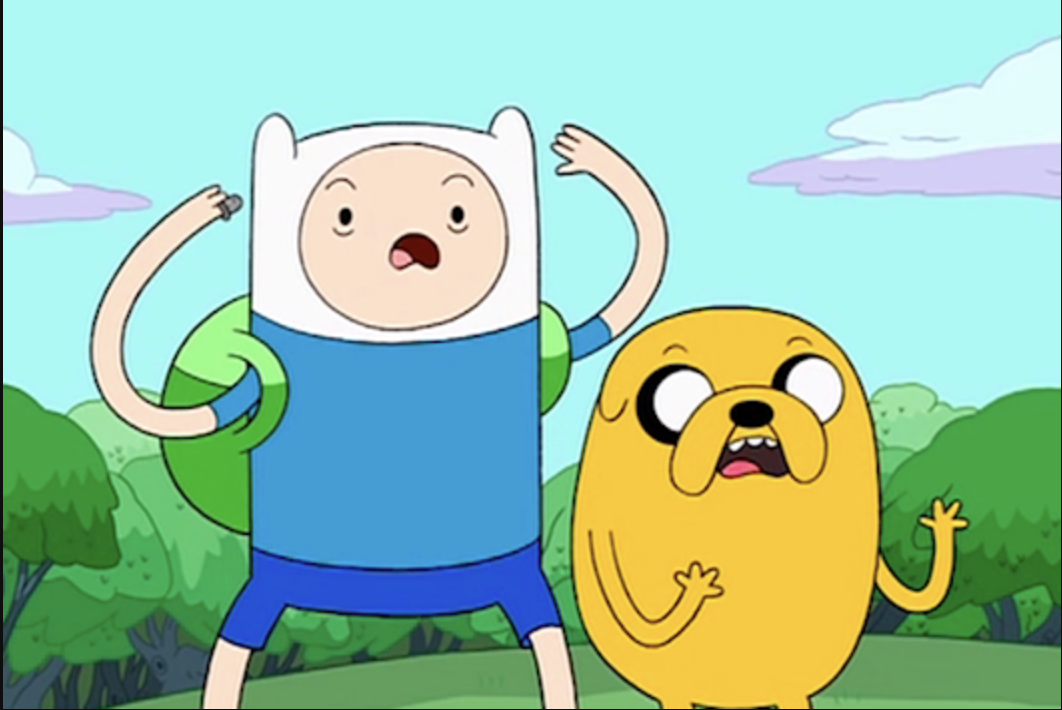

Clone the repository: https://github.com/dlt-hub/dlthub-education.git

In [ ]:
!git clone https://github.com/dlt-hub/dlthub-education.git

Cloning into 'dlthub-education'...
remote: Enumerating objects: 291, done.
remote: Counting objects: 100% (291/291), done.
remote: Compressing objects: 100% (206/206), done.
remote: Total 291 (delta 122), reused 217 (delta 58), pack-reused 0 (from 0)
Receiving objects: 100% (291/291), 16.95 MiB | 24.41 MiB/s, done.
Resolving deltas: 100% (122/122), done.
